In [1]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 3
fh = 1

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh, use_neighbours=False)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X.shape, y.shape

((1429, 25, 45, 3, 6), (1429, 25, 45, 1, 6))

<LINEAR>
t2m => RMSE:  2.01003; SE: 0.03804538822322544
sp => RMSE:  1.77565; SE: 0.5929344035917864
tcc => RMSE:  0.2835; SE: 0.006463310819156775
u10 => RMSE:  1.4896; SE: 0.053224365545897906
v10 => RMSE:  2.23722; SE: 0.0433727751208579
tp => RMSE:  0.00024; SE: 7.197806686884264e-06


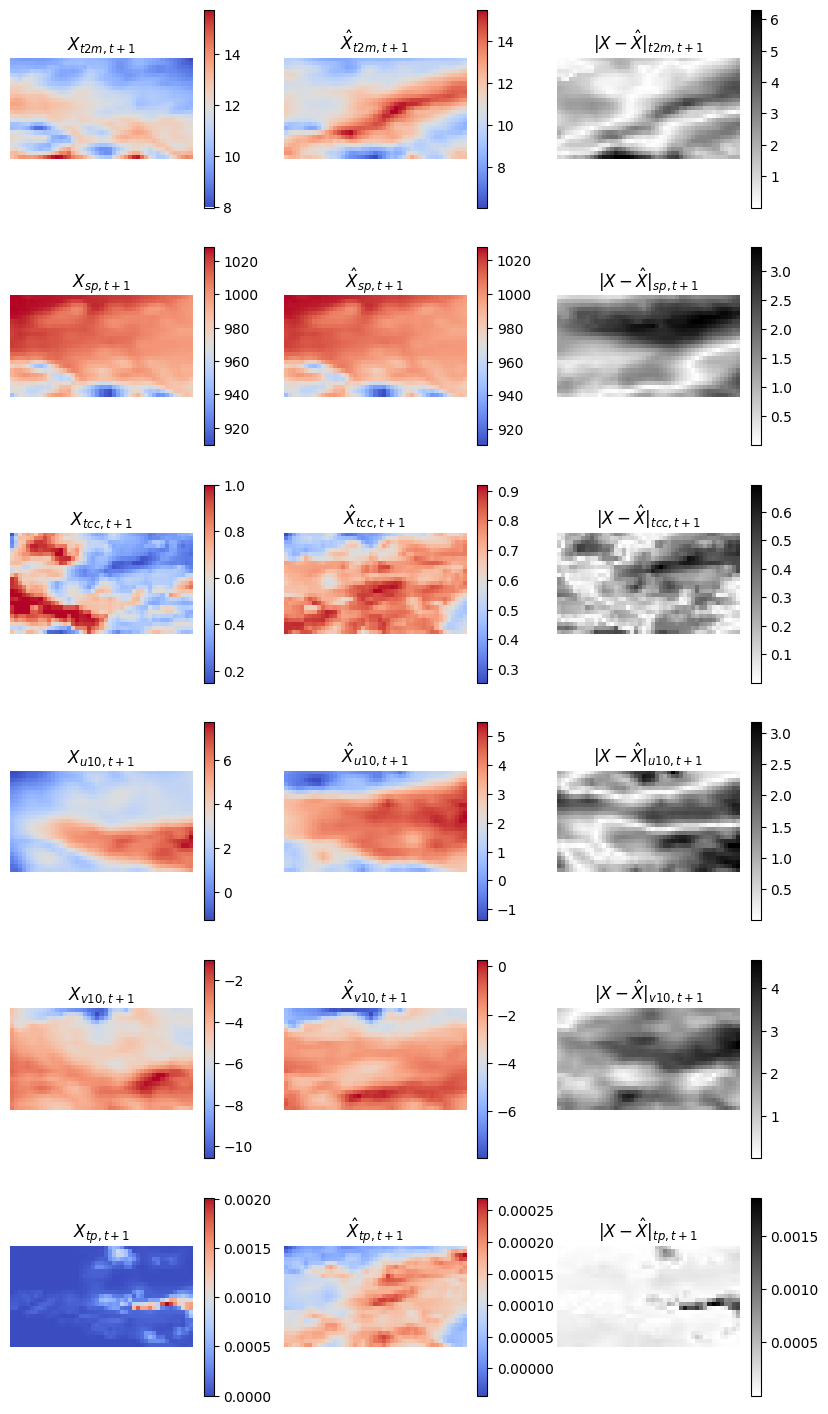

Evaluation metrics for entire test set:
t2m => RMSE: 2.626; SE: 0.010200797752953046
sp => RMSE: 1.176; SE: 0.03702956939722691
tcc => RMSE: 0.257; SE: 0.0004828579478474195
u10 => RMSE: 1.432; SE: 0.005026088934293758
v10 => RMSE: 1.221; SE: 0.004110117665590181
tp => RMSE: 0.0; SE: 3.4696299529253065e-07

<LASSO>
t2m => RMSE:  1.27714; SE: 0.03804538822322544
sp => RMSE:  1.96237; SE: 0.5929344035917864
tcc => RMSE:  0.21935; SE: 0.006463310819156775
u10 => RMSE:  1.49534; SE: 0.053224365545897906
v10 => RMSE:  2.91883; SE: 0.0433727751208579
tp => RMSE:  0.00024; SE: 7.197806686884264e-06


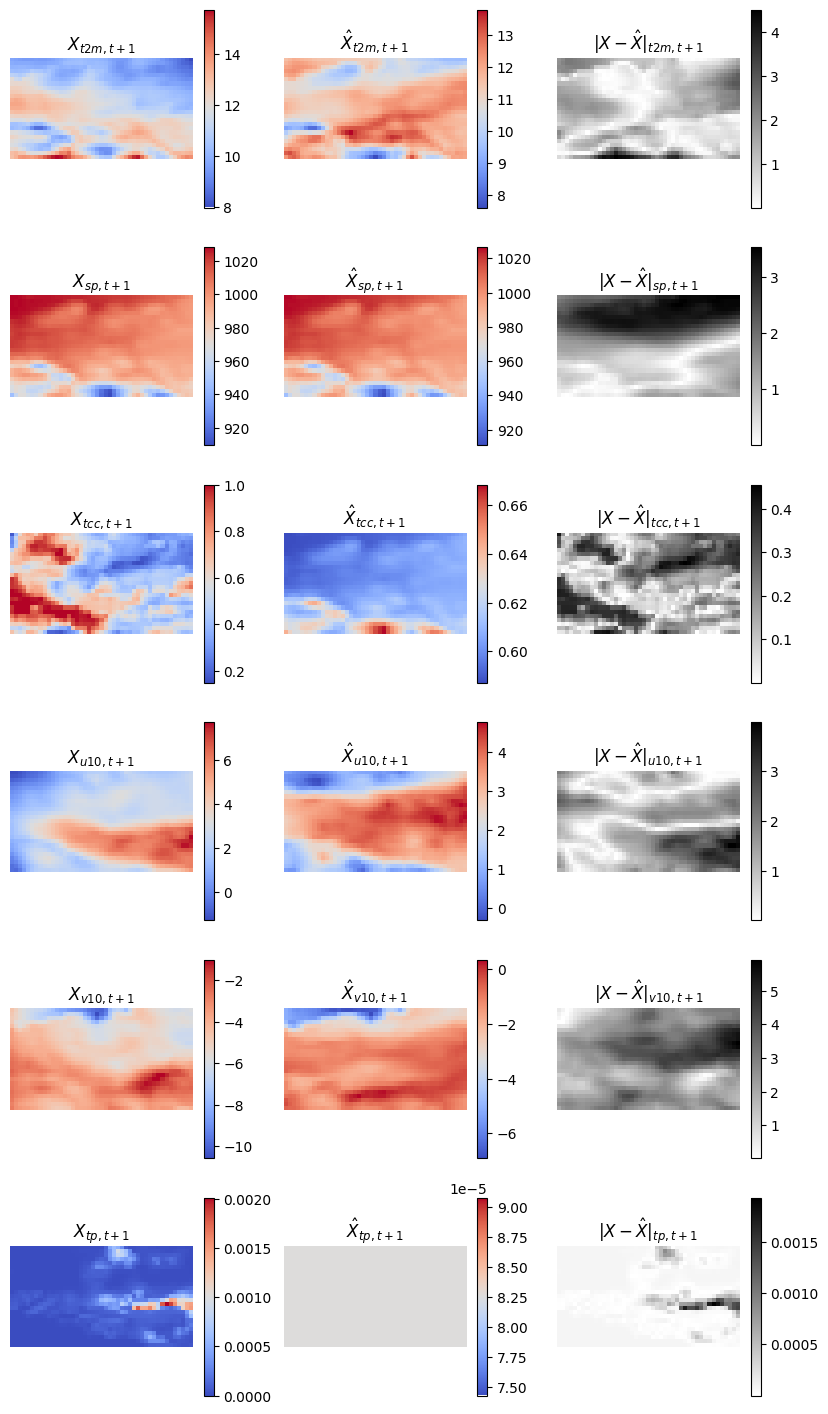

Evaluation metrics for entire test set:
t2m => RMSE: 2.53; SE: 0.010200797752953046
sp => RMSE: 1.578; SE: 0.03702956939722691
tcc => RMSE: 0.355; SE: 0.0004828579478474195
u10 => RMSE: 1.482; SE: 0.005026088934293758
v10 => RMSE: 1.436; SE: 0.004110117665590181
tp => RMSE: 0.0; SE: 3.4696299529253065e-07

<RIDGE>
t2m => RMSE:  1.878; SE: 0.03804538822322544
sp => RMSE:  1.79523; SE: 0.5929344035917864
tcc => RMSE:  0.27609; SE: 0.006463310819156775
u10 => RMSE:  1.48549; SE: 0.053224365545897906
v10 => RMSE:  2.23959; SE: 0.0433727751208579
tp => RMSE:  0.00024; SE: 7.197806686884264e-06


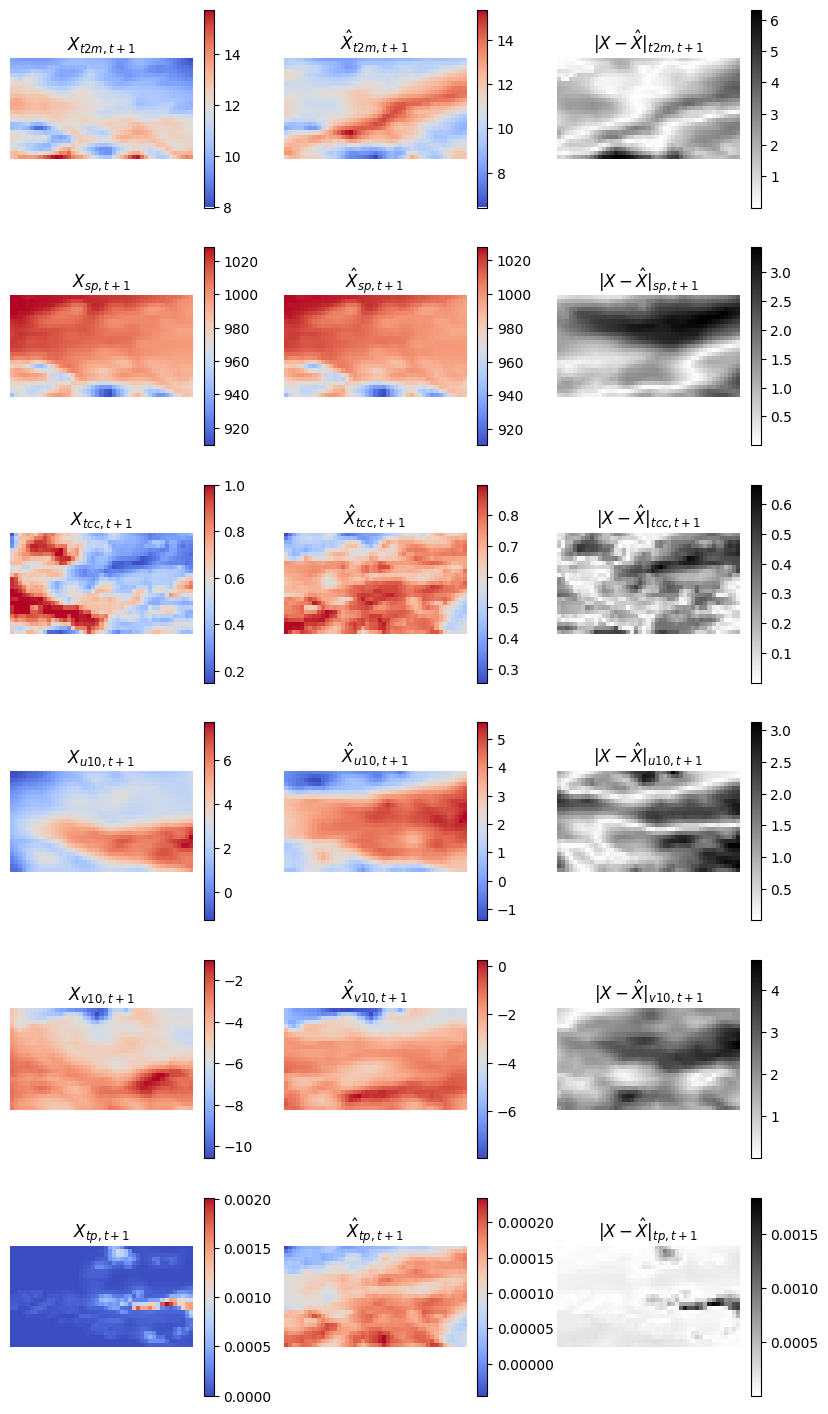

Evaluation metrics for entire test set:
t2m => RMSE: 2.622; SE: 0.010200797752953046
sp => RMSE: 1.186; SE: 0.03702956939722691
tcc => RMSE: 0.257; SE: 0.0004828579478474195
u10 => RMSE: 1.45; SE: 0.005026088934293758
v10 => RMSE: 1.226; SE: 0.004110117665590181
tp => RMSE: 0.0; SE: 3.4696299529253065e-07

<ELASTIC_NET>
t2m => RMSE:  1.25936; SE: 0.03804538822322544
sp => RMSE:  1.75676; SE: 0.5929344035917864
tcc => RMSE:  0.21761; SE: 0.006463310819156775
u10 => RMSE:  1.48581; SE: 0.053224365545897906
v10 => RMSE:  2.83143; SE: 0.0433727751208579
tp => RMSE:  0.00024; SE: 7.197806686884264e-06


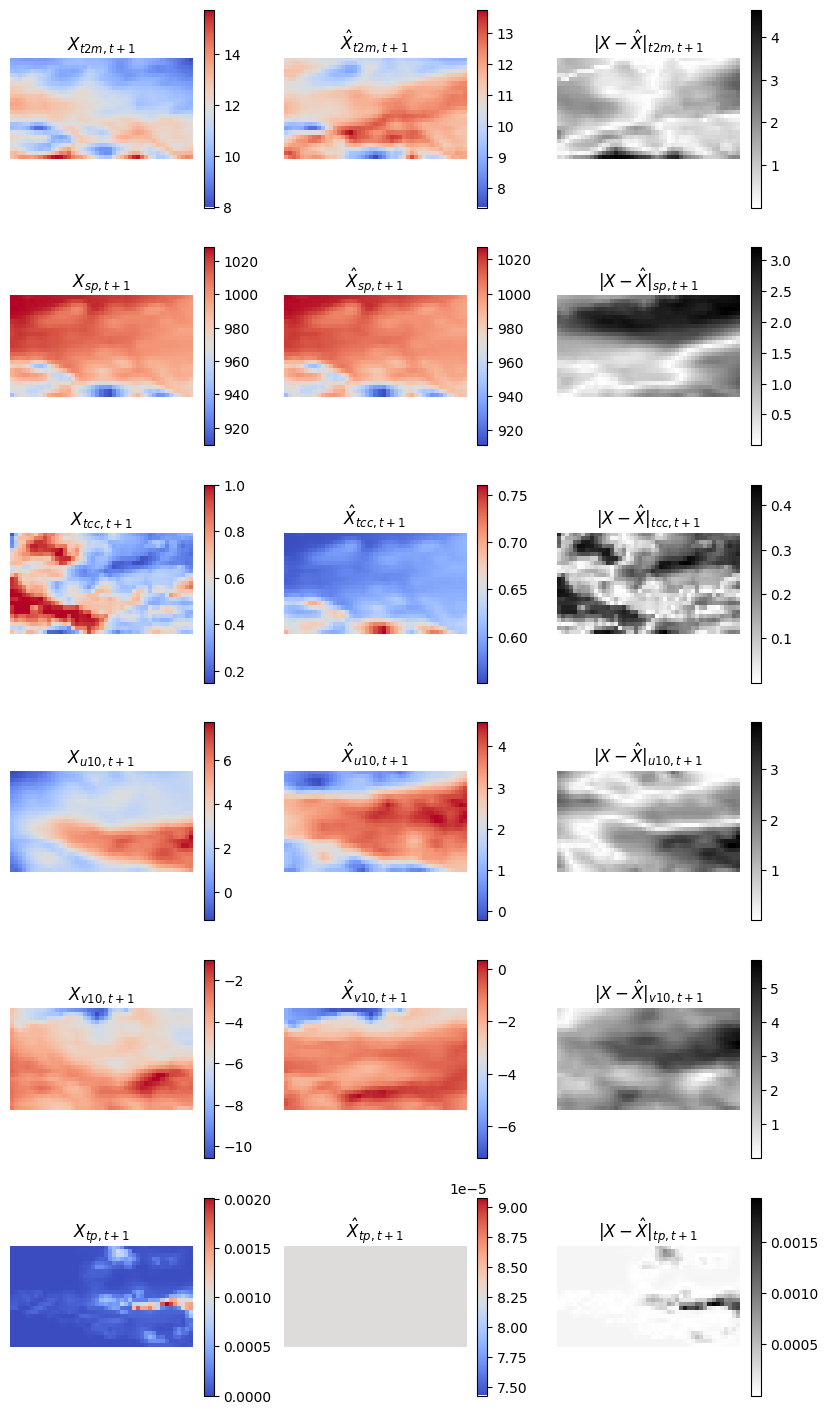

Evaluation metrics for entire test set:
t2m => RMSE: 2.551; SE: 0.010200797752953046
sp => RMSE: 1.486; SE: 0.03702956939722691
tcc => RMSE: 0.357; SE: 0.0004828579478474195
u10 => RMSE: 1.509; SE: 0.005026088934293758
v10 => RMSE: 1.384; SE: 0.004110117665590181
tp => RMSE: 0.0; SE: 3.4696299529253065e-07



In [12]:
available_reg = ['linear', 'lasso', 'ridge', 'elastic_net']
for reg in available_reg:
    print(f'<{reg.upper()}>')
    linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
    linearreg.train(X_train, y_train)
    _ = linearreg.predict_and_evaluate(X_test, y_test, max_samples=1)
    print()